##### 生成线性方程组的哈密顿量，在真机噪声的环境下使用 VQE 求解得到基态及其基态能量，初始参数由最优参数随机扰动形成，尝试进行迭代优化，并与无噪进行对比。

注意，本文件运行是需要包含的 qiskit 的环境，用于引入噪声，即 requirements_noise

In [1]:
# 导入必要的库
import time
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from pennylane import numpy as qml_np

# 引入真机噪声
from qiskit_aer import noise
from qiskit_aer import AerSimulator, Aer
import pickle

# 自己构造的函数
import hamiltonian_until
import VQE_until

In [2]:
# 参数设置
steps = 10  # 迭代次数
eta = 0.4  # 学习率
seed = 1024 # 种子数
tol = 1e-4 # 终止条件
deep_layer = 1 # 电路层数


# 量子数
tol_qubits = hamiltonian_until.tol_qubits

# 一层电路时的最优参数
params_old = qml_np.array([4.71237303, 4.7124589,  1.57078406, 4.71237222, 4.71235171, 1.5708085,
 1.57080377, 1.57074532, 1.57081405, 4.71238723, 1.57089928, 4.71242189])

# 在最优参数附近，添加扰动
error = qml_np.random.uniform(low=-0.5, high=0.5, size=(deep_layer * tol_qubits,))

params = params_old + error
# params = params_old
print("error = ", error)
print("params = ", params)

error =  [ 0.4492667  -0.42448014  0.0134753   0.15472742  0.16507589 -0.31506694
  0.01497241  0.35614091 -0.41607379 -0.22661082  0.26570597  0.07882925]
params =  [5.16163973 4.28797876 1.58425936 4.86709964 4.8774276  1.25574156
 1.58577618 1.92688623 1.15474026 4.48577641 1.83660525 4.79125114]


In [3]:
# 加载真机噪声
def configure_backend():
    with open('NoiseModel/fakemontreal.pkl', 'rb') as file:
        noise_model = noise.NoiseModel().from_dict(pickle.load(file))
    backend = AerSimulator(
        method='statevector',
        noise_model=noise_model,
    )

    # backend.set_options(device='GPU')
    return backend

# 构造设备
# 有噪
dev_noise = qml.device('qiskit.aer', wires=tol_qubits, shots=None, backend=configure_backend())
dev_noise_sample = qml.device('qiskit.aer', wires=tol_qubits, shots=1024, backend=configure_backend())

# 无噪
dev_ideal = qml.device("default.qubit", wires=tol_qubits, shots=None)
dev_ideal_sample = qml.device("default.qubit", wires=tol_qubits, shots=1024)

# 定义损失函数
cost_fn = VQE_until.variational_circuit_expval # 返回哈密顿量期望值
prob_fn = VQE_until.variational_circuit_prob   # 返回电路的概率 

# 创建运行节点
qnode_noise = qml.QNode(cost_fn, dev_noise)
qnode_noise_sample = qml.QNode(cost_fn, dev_noise_sample)

qnode_ideal = qml.QNode(cost_fn, dev_ideal)
qnode_ideal_sample = qml.QNode(cost_fn, dev_ideal_sample)


# 创建返回电路各基态概率的节点
qnode_noise_prob = qml.QNode(prob_fn, dev_noise)
qnode_noise_sample_prob = qml.QNode(prob_fn, dev_noise_sample)

qnode_ideal_prob = qml.QNode(prob_fn, dev_ideal)
qnode_ideal_sample_prob = qml.QNode(prob_fn, dev_ideal_sample)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9944\2943898470.py:4: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  noise_model = noise.NoiseModel().from_dict(pickle.load(file))
f:\Users\Administrator\anaconda3\envs\pennylane_mitigated\lib\site-packages\pennylane_qiskit\qiskit_device.py:162: UserWarning: The analytic calculation of expectations, variances and probabilities is only supported on statevector backends, not on the aer_simulator_statevector. Such statistics obtained from this device are estimates based on samples.
  warnings.warn(self.hw_analytic_warning_message.format(backend), UserWarning)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_9944\2943898470.py:4: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  noise_model = noise.NoiseModel().from_dict(pickle.load(file))


In [4]:
# 基于非测量的节点的出值对比
noise_value = qnode_noise(params, deep_layer)
ideal_value = qnode_ideal(params, deep_layer)

noise_prob = qnode_noise_prob(params, deep_layer)
ideal_prob = qnode_ideal_prob(params, deep_layer)

print("noise_value = ", noise_value)
print("noise_prob 940 = ", noise_prob[940])

print("ideal_value = ", ideal_value)
print("ideal_prob 940 = ", ideal_prob[940])

noise_value =  4671.0498046875
noise_prob 940 =  0.7646484375
ideal_value =  5074.735045812266
ideal_prob 940 =  0.7853045632197279


In [5]:
# 基于测量的节点的出值对比
noise_sample_value = qnode_noise_sample(params, deep_layer)
ideal_sample_value = qnode_ideal_sample(params, deep_layer)

noise_sample_prob = qnode_noise_sample_prob(params, deep_layer)
ideal_sample_prob = qnode_ideal_sample_prob(params, deep_layer)

print("noise_sample_value = ", noise_sample_value)
print("noise_sample_prob 940 = ", noise_sample_prob[940])

print("ideal_sample_value = ", ideal_sample_value)
print("ideal_sample_prob 940 = ", ideal_sample_prob[940])

noise_sample_value =  6681.3671875
noise_sample_prob 940 =  0.77734375
ideal_sample_value =  5199.890625
ideal_sample_prob 940 =  0.7861328125


In [6]:
# 不考虑测量，直接进行迭代优化

# 优化器
# opt = qml.GradientDescentOptimizer(stepsize=0.1)
opt = qml.AdamOptimizer(stepsize=eta)

qml_np.random.seed(seed)

# 存储损失值和参数
noise_cost_history = []
noise_params_history = [params]

for it in range(steps):
    
    start = time.time()
    
    params_lsit, cost = opt.step_and_cost(qnode_noise, params, deep_layer)
    # print("params_lsit = ", params_lsit)
    # print("cost = ", cost)

    # 返回来的 list，包含参数和deep_layer等
    params = params_lsit[0]
    # 存储每一次更新后的参数及损失值
    noise_params_history.append(params)
    noise_cost_history.append(cost)
    
    end = time.time()
    
    if it % 2:
        print(f"Step = {it},  Energy = {noise_cost_history[-1]:.8f}, Time = {end - start}")

    # 终止条件
    if len(noise_cost_history) !=1 and abs(noise_cost_history[-1] - noise_cost_history[-2]) < tol:
        break    

# 上述存储过程，energy_list 比 params_list 少了最后一项       
noise_cost_history.append(qnode_noise(params, deep_layer))

print("\n" f"Final value of the ground-state energy = {noise_cost_history[-1]:.8f}")
print("\n" f"Optimal value of the circuit parameter = {noise_params_history[-1]}")

Step = 1,  Energy = 3097.85058594, Time = 3181.739690065384
Step = 3,  Energy = 3357.26269531, Time = 3188.7011816501617
Step = 5,  Energy = 18909.94921875, Time = 3197.437467813492
Step = 7,  Energy = 1819.75585938, Time = 3238.472232580185
Step = 9,  Energy = 4178.85156250, Time = 3317.802481174469

Final value of the ground-state energy = 6325.69238281

Optimal value of the circuit parameter = [4.55298965 4.49180278 1.50765422 4.88895401 4.65764962 1.07404392
 1.68486474 1.90871567 1.43820582 4.7905775  1.47480147 4.70484817]


In [7]:
# 无噪声情况下的迭代优化，且不进行测量

# 存储损失值和参数
ideal_cost_history = []
ideal_params_history = [params]

for it in range(steps):
    
    start = time.time()
    
    params_lsit, cost = opt.step_and_cost(qnode_ideal, params, deep_layer)
    # print("params_lsit = ", params_lsit)
    # print("cost = ", cost)

    # 返回来的 list，包含参数和deep_layer等
    params = params_lsit[0]
    # 存储每一次更新后的参数及损失值
    ideal_params_history.append(params)
    ideal_cost_history.append(cost)
    
    end = time.time()
    
    if it % 2:
        print(f"Step = {it},  Energy = {ideal_cost_history[-1]:.8f}, Time = {end - start}")

    # 终止条件
    if len(ideal_cost_history) !=1 and abs(ideal_cost_history[-1] - ideal_cost_history[-2]) < tol:
        break    

# 上述存储过程，energy_list 比 params_list 少了最后一项       
ideal_cost_history.append(qnode_ideal(params, deep_layer))

print("\n" f"Final value of the ground-state energy = {ideal_cost_history[-1]:.8f}")
print("\n" f"Optimal value of the circuit parameter = {ideal_params_history[-1]}")

Step = 1,  Energy = 1726.99572623, Time = 5.1053221225738525
Step = 3,  Energy = 898.47784547, Time = 5.224059343338013
Step = 5,  Energy = 1612.57142596, Time = 5.485656023025513
Step = 7,  Energy = 1474.25726110, Time = 5.539215803146362
Step = 9,  Energy = 361.15408238, Time = 5.279855728149414

Final value of the ground-state energy = 345.07043820

Optimal value of the circuit parameter = [4.71080248 4.53416023 1.49195836 4.76065032 4.70325846 1.66726905
 1.55718063 1.64066633 1.47948966 4.72509977 1.50288049 4.70799253]


abs error noise =  6461.6923828125
abs error ideal =  481.07043819908864


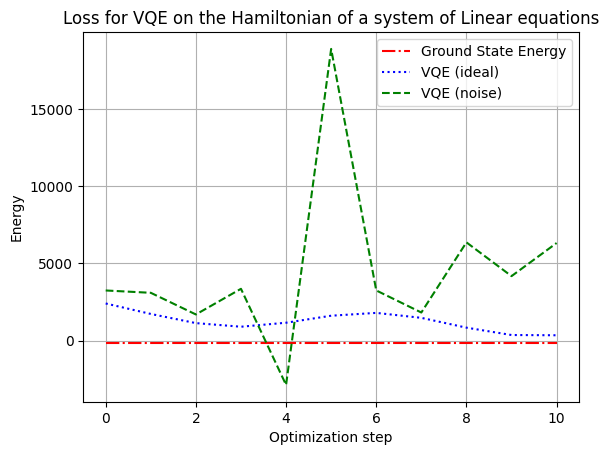

In [8]:
min_eigenvalue = hamiltonian_until.min_eigenvalue

print("abs error noise = ", abs(min_eigenvalue - noise_cost_history[-1]))
print("abs error ideal = ", abs(min_eigenvalue - ideal_cost_history[-1]))

length = max(len(ideal_cost_history), len(noise_cost_history))

# 绘图比较
plt.grid()
plt.plot(range(length), min_eigenvalue * np.ones(length), color='r', linestyle='-.', label='Ground State Energy')
plt.plot(range(len(ideal_cost_history)), ideal_cost_history, color='b', linestyle=':', label='VQE (ideal)')
plt.plot(range(len(noise_cost_history)), noise_cost_history, color='g', linestyle='--', label='VQE (noise)')

plt.xlabel('Optimization step')
plt.ylabel('Energy')

plt.legend()
plt.title(f'Loss for VQE on the Hamiltonian of a system of Linear equations')
plt.show()

In [9]:
# 正确答案的量子态
min_eigenvector = hamiltonian_until.min_eigenvector


# 返回测量概率
noise_prob = qnode_noise_prob(noise_params_history[-1], deep_layer)
ideal_prob = qnode_ideal_prob(ideal_params_history[-1], deep_layer)

print("noise_prob = ", noise_prob)
print("noise_prob 940 = ", noise_prob[940])

print("ideal_prob = ", ideal_prob)
print("ideal_prob 940 = ", ideal_prob[940])

noise_prob =  [0. 0. 0. ... 0. 0. 0.]
noise_prob 940 =  0.873046875
ideal_prob =  [4.85936268e-19 1.17962295e-32 2.03473596e-21 ... 1.62445298e-23
 1.47755661e-30 3.87952361e-21]
ideal_prob 940 =  0.9831552692199108
